unet and resnet

In [1]:
import numpy as np # linear algebra
import pandas as pd # 

In [2]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model

C:\Users\teeru\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
from keras.layers import Input, UpSampling2D, BatchNormalization
from keras.layers.core import Lambda
from keras.layers.convolutional import Conv2D, SeparableConv2D
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint, Callback
from keras import backend as K
from keras.applications.resnet50 import ResNet50,preprocess_input

In [4]:
import warnings
warnings.filterwarnings('ignore', category=UserWarning, module='skimage')

import os
from skimage.io import imread, imshow
from skimage.transform import resize
from skimage.morphology import label
from skimage.util import crop
from skimage.transform import resize
from skimage.segmentation import find_boundaries, mark_boundaries
from scipy.ndimage.morphology import binary_erosion as erosion
from scipy.ndimage.morphology import binary_dilation as dilation
from scipy.ndimage import distance_transform_edt
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
train_path = 'D:/UTA/Fall term/Advanced Predictive modelling/Project/Data/train_color'
label_path = 'D:/UTA/Fall term/Advanced Predictive modelling/Project/Data/train_labelS'
def get_data():
    label = os.listdir(label_path)
    label.sort()
    train = os.listdir(train_path)
    train.sort()
    df_id = pd.DataFrame()
    df_id['label'] = label
    df_id['train'] = train
    df_id['label_path'] = df_id['label'].apply(lambda x: os.path.join(label_path, x))
    df_id['train_path'] = df_id['train'].apply(lambda x: os.path.join(train_path, x))
    return df_id

In [10]:
df_id = get_data()

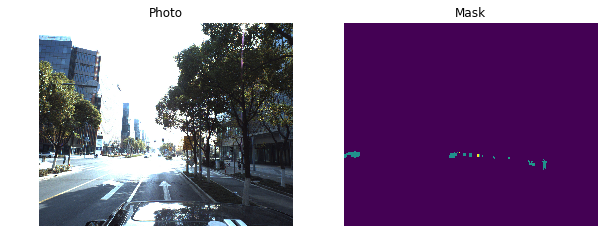

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1292 entries, 0 to 1291
Data columns (total 4 columns):
label         1292 non-null object
train         1292 non-null object
label_path    1292 non-null object
train_path    1292 non-null object
dtypes: object(4)
memory usage: 40.5+ KB
None


,label,train,label_path,train_path
0,171206_034325814_Camera_5_instanceIds.png,171206_034325814_Camera_5.jpg,D:/UTA/Fall term/Advanced Predictive modelling...,D:/UTA/Fall term/Advanced Predictive modelling...
1,171206_034325814_Camera_6_instanceIds.png,171206_034325814_Camera_6.jpg,D:/UTA/Fall term/Advanced Predictive modelling...,D:/UTA/Fall term/Advanced Predictive modelling...
2,171206_034325959_Camera_5_instanceIds.png,171206_034325959_Camera_5.jpg,D:/UTA/Fall term/Advanced Predictive modelling...,D:/UTA/Fall term/Advanced Predictive modelling...
3,171206_034325959_Camera_6_instanceIds.png,171206_034325959_Camera_6.jpg,D:/UTA/Fall term/Advanced Predictive modelling...,D:/UTA/Fall term/Advanced Predictive modelling...
4,171206_034326104_Camera_5_instanceIds.png,171206_034326104_Camera_5.jpg,D:/UTA/Fall term/Advanced Predictive modelling...,D:/UTA/Fall term/Advanced Predictive modelling...


In [13]:
ix = np.random.randint(0, len(df_id.index))
train_ex = imread(df_id.loc[ix, 'train_path'])
label_ex = imread(df_id.loc[ix, 'label_path'])
f, ax = plt.subplots(1,2, figsize = (10,10))
ax[0].imshow(train_ex)
ax[1].imshow(np.squeeze(label_ex))
ax[0].axis('off')
ax[1].axis('off')
ax[0].set_title('Photo')
ax[1].set_title('Mask')
plt.show()
print(df_id.info())
df_id.head()

In [ ]:
test_path = '../input/test'
def get_test_data():
    test = os.listdir(test_path)
    test.sort()
    df_id = pd.DataFrame()
    df_id['test'] = test
    df_id['test_path'] = df_id['test'].apply(lambda x: os.path.join(test_path, x))
    return df_id

df_test_id = get_test_data()
plt.imshow(imread(df_test_id.sample(n = 1)['test_path'].values[0]))
plt.axis('off')
print(df_test_id.info())
df_test_id.head()

In [14]:
labelmap_target = {33:'car', 34:'motorbicycle', 35:'bicycle', 36:'person', 38:'truck', 39:'bus', 40:'tricycle'}

In [15]:
datagen_arg = dict(horizontal_flip = True)

maskgen_arg = dict(horizontal_flip = True)

# ImageDataGenerator generates batches of tensor image data with real-time data augmentation. 
# The data will be looped over (in batches)
# **datagen_arg - seems like a way to pass arguments to the generator
# Not sure why we need this or why we want the horizontal_flip to be True

x_gen = ImageDataGenerator(**datagen_arg)
mask_gen = ImageDataGenerator(**maskgen_arg)

In [94]:
#a custom generator that outputs x and y
#x is the raw input unit 8 image
# y is the 7 dims array of masks
def label_to_mask(y, classes):
    mask_core = np.zeros((y.shape[0], y.shape[1], len(classes)))
    mask_edge = np.zeros((y.shape[0], y.shape[1], 1))
    #is foreground defined as all the pixels where the relevant classes are found? How can a pixel values be greater than 33000?
    foreground = (y*((y >= classes[0]*1000) & (y < (classes[-1]+1)*1000))).astype(np.uint16)
    unique_objects = np.delete(np.unique(foreground), 0)
    # mask core
    for i, class_ in enumerate(classes):
        #check class for each pixel in foreground
        mask_core[:,:,i] = np.squeeze(((foreground/1000).astype(np.int32) == class_).astype(np.bool))
    # This operation makes the edge ~2 pixels thick,
    # remember to fill the pixels back in post processing
    mask_edge = find_boundaries(foreground, mode = 'outer').astype(np.bool)
    return mask_core, mask_edge

In [19]:
def resize_random_crop(images, random_state, resize_w = 1280, resize_h = 720, crop_w = 224, crop_h = 224):
    np.random.seed(random_state)
    # function to shrink and random crop input to desired size for training
    # resize is done so random crop won't output images with no targets too often
    images = np.array([resize(image, (resize_h, resize_w), mode = 'constant', preserve_range = True) for image in images])
    height = images.shape[1]
    width = images.shape[2]
    # The randn function is to prevent data augmentation from producing too many crop with sky only
    rand_h_start = (np.clip(0.9*np.random.randn()+0.7, 0, 1)*(height - crop_h)).astype(np.uint16)
    rand_w_start = np.random.randint(0, (width - crop_w))
    return crop(images, ((0, 0), (rand_h_start, height - (rand_h_start + crop_h)),
                        (rand_w_start, width - (rand_w_start + crop_w)), (0, 0)))

In [20]:
def augmentation_checker(mask, classes, percentage = 0.005):
    # function to ensure that the cropped input has at least some mask in it
    mask_core, mask_edge = label_to_mask(mask, classes)
    while np.mean(mask_core) < percentage:
        mask_core, mask_edge = label_to_mask(mask, classes)
    return mask_core, mask_edge

In [95]:
def data_generator(x_gen_, mask_gen_, df_data, mini_bat_size, classes = sorted(labelmap_target.keys())):
    while True:
        seed = np.random.randint(0,1000)
        sampled_set = df_data.sample(n = mini_bat_size)
        sampled_train = sampled_set['train_path']
        sampled_label = sampled_set['label_path']
        X = preprocess_input(np.array([imread(train_path) for train_path in sampled_train]).astype(np.float32))
        #axis = -1 is the position where the new axis is placed. Why do we add this extra axis?
        y = np.expand_dims(np.array([imread(label_path) for label_path in sampled_label]), axis = -1)

        x_generator = x_gen_.flow(X, batch_size = mini_bat_size, seed = seed)
        mask_generator = mask_gen_.flow(y, batch_size = mini_bat_size, seed = seed)
        X = resize_random_crop(x_generator.next(), seed)
        y = resize_random_crop(mask_generator.next(), seed)
        y_mask = []
        y_edge = []
        for mask in y:
            mask_core, mask_edge = label_to_mask(mask, classes)
            y_mask.append(mask_core)
            y_edge.append(mask_edge)
        yield (X, {'masks': np.array(y_mask), 'edges': np.array(y_edge)})

In [96]:
mini_bat_size = 2
X, y= next(data_generator(x_gen, mask_gen, df, mini_bat_size))

In [105]:
ix = 1
X_cropped = X[ix]
y_edge_cropped = np.squeeze(y['edges'][ix])
y_mask_cropped = np.squeeze(y['masks'][ix,:,:,0])
#creating label minus the edge - so tht if we have two insgtances close together we can separate them
y_mask_seg = y_mask_cropped - y_edge_cropped

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5,1,'post: segmented by instance')

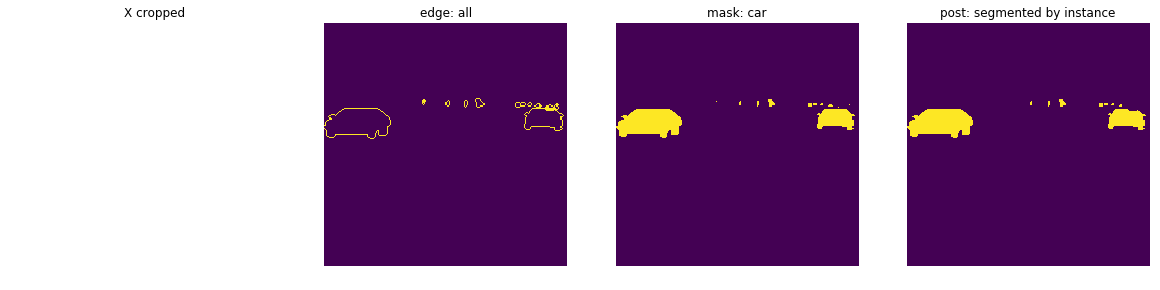

In [106]:
f, ax = plt.subplots(1,4, figsize = (20,20))
ax[0].imshow(X_cropped/255 + 150) # This is my lazy work to roughly undo preprocessing for this visualization
ax[0].axis('off')
ax[0].set_title('X cropped')
ax[1].imshow(y_edge_cropped)
ax[1].axis('off')
ax[1].set_title('edge: all')
ax[2].imshow(y_mask_cropped)
ax[2].axis('off')
ax[2].set_title('mask: car')
ax[3].imshow(y_mask_seg > 0)
ax[3].axis('off')
ax[3].set_title('post: segmented by instance')

# Building ResNet

In [109]:
R50 = ResNet50(include_top = False, input_shape = (224, 224, 3))

C:\Users\teeru\Anaconda3\lib\site-packages\keras_applications\resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


94658560/94653016 [==============================] - 4s 0us/step


In [110]:
# pop off the last pooling layer
R50.layers.pop()
for layer in R50.layers:
    layer.trainable = False

In [111]:
# Layers from ResNet50 to make skip connections
skip_ix = [172, 140, 78, 36, 3]
# Layers in decoder to connect to encoder
skip_end = []
for i in skip_ix:
    skip_end.append(R50.layers[i])

In [112]:
R50.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [114]:
# Use billinear additive upsampling (BAU) and separable convolution to reduce the total amount of hyperparameters
def BAU_layer(last_layer, channel_num):
    additive = []
    depth = int(last_layer.get_shape()[-1])
    step = int(depth / channel_num)
    last_layer[:, :, :, 1*step:(1*step+step)]
    for i in range(channel_num):
        layersum = K.mean(last_layer[:, :, :, i*step:(i*step+step)], axis = -1)
        additive.append(layersum)
    additive = K.stack(additive, axis = -1)
    return additive

def upsampling_step(skipped_conv, num_output_filters, prev_conv = None):
    num_filters = skipped_conv.output_shape[-1]
    if prev_conv != None:
        concat_layer = concatenate([skipped_conv.output, prev_conv])
    else:
        concat_layer = skipped_conv.output
    conv1 = SeparableConv2D(num_filters, 3, padding = 'same', activation = 'relu',
                           depthwise_initializer = 'he_normal', pointwise_initializer = 'he_normal')(concat_layer)
    conv2 = SeparableConv2D(num_filters, 3, padding = 'same', activation = 'relu',
                           depthwise_initializer = 'he_normal', pointwise_initializer = 'he_normal')(conv1)
    up = UpSampling2D()(conv2)
    BAU = Lambda(BAU_layer, arguments = {'channel_num': num_output_filters})(up)
    conv3 = SeparableConv2D(num_output_filters, 2, padding = 'same', activation = 'relu',
                           depthwise_initializer = 'he_normal', pointwise_initializer = 'he_normal')(BAU)
    return conv3

def output(feature_map, mask = True):
    if mask:
        conv3 = Conv2D(7, 1, padding = 'same', activation = 'sigmoid', kernel_initializer = 'he_normal', name = 'masks')(feature_map)
    else:
        conv3 = Conv2D(1, 1, padding = 'same', activation = 'sigmoid', kernel_initializer = 'he_normal', name = 'edges')(feature_map)
    return conv3

In [116]:
up_num_filters = [1024, 512, 256, 64, 64]
for n, i in enumerate(up_num_filters):
    if n == 0:
        conv_layer = upsampling_step(skip_end[n], i)
    else:
        conv_layer = upsampling_step(skip_end[n], i, conv_layer)
conv1 = Conv2D(64, 3, padding = 'same', activation = 'relu', kernel_initializer = 'he_normal')(conv_layer)
conv2 = Conv2D(64, 3, padding = 'same', activation = 'relu', kernel_initializer = 'he_normal')(conv1)

masks = output(conv2)
edges = output(conv2, False)
model = Model(inputs = R50.inputs, outputs = [masks, edges])

In [120]:
model.compile(optimizer = 'adam', loss = {'masks': 'binary_crossentropy', 'edges': 'binary_crossentropy'})

# Optional callbacks
# checkpointer = ModelCheckpoint('./models/ResNet50_U-Net_chkpt.h5', verbose = 1, save_best_only = True)
# tbCallback = TensorBoard(log_dir = './Graph', histogram_freq = 0, write_graph = True, write_images = True)
# earlystopper = EarlyStopping(patience = 5, verbose = 1)
bat_size = 2
result = model.fit_generator(data_generator(x_gen, mask_gen, df_id, bat_size), steps_per_epoch = bat_size, epochs = 50,
                            verbose = 1)

Epoch 1/50
2/2 [==============================] - 102s 51s/step - loss: 1.3830 - masks_loss: 0.6927 - edges_loss: 0.6902
Epoch 2/50
2/2 [==============================] - 24s 12s/step - loss: 1.3567 - masks_loss: 0.6881 - edges_loss: 0.6686
Epoch 3/50
2/2 [==============================] - 21s 11s/step - loss: 1.3017 - masks_loss: 0.6780 - edges_loss: 0.6237
Epoch 4/50
2/2 [==============================] - 27s 13s/step - loss: 1.1862 - masks_loss: 0.6568 - edges_loss: 0.5293
Epoch 5/50
2/2 [==============================] - 29s 14s/step - loss: 1.0027 - masks_loss: 0.6226 - edges_loss: 0.3801
Epoch 6/50
2/2 [==============================] - 27s 13s/step - loss: 0.7162 - masks_loss: 0.5358 - edges_loss: 0.1804
Epoch 7/50
2/2 [==============================] - 25s 13s/step - loss: 0.4532 - masks_loss: 0.4023 - edges_loss: 0.0509
Epoch 8/50
2/2 [==============================] - 26s 13s/step - loss: 0.2901 - masks_loss: 0.2680 - edges_loss: 0.0221
Epoch 9/50
2/2 [=======================

ResourceExhaustedError: OOM when allocating tensor with shape[2,56,56,512] and type float on /job:localhost/replica:0/task:0/device:CPU:0 by allocator cpu
	 [[{{node training/Adam/gradients/lambda_8/strided_slice_186_grad/StridedSliceGrad}} = StridedSliceGrad[Index=DT_INT32, T=DT_FLOAT, begin_mask=7, ellipsis_mask=0, end_mask=7, new_axis_mask=0, shrink_axis_mask=0, _device="/job:localhost/replica:0/task:0/device:CPU:0"](training/Adam/gradients/lambda_8/strided_slice_186_grad/Shape, lambda_8/strided_slice_185/stack_1, lambda_8/strided_slice_186/stack_1, lambda_10/strided_slice_1/stack_2, training/Adam/gradients/lambda_8/Mean_185_grad/truediv)]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.


In [ ]:
score = model.evaluate(x_test, y_test, verbose=0) 
score[1]

# Notes on python coding
1. Imread returns (W,H, channels)
2. Image.open returns (H,W)
3. np.expand_dims() Expand the shape of an array.Insert a new axis that will appear at the axis position in the expanded array shape.
4. .flow() to read the images from a big numpy array containing images

In [84]:
c1=sorted(labelmap_target.keys())
c1

[33, 34, 35, 36, 38, 39, 40]

In [87]:
m_core = np.zeros((3, 2, 7))
m_core

array([[[0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.]],

       [[0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.]],

       [[0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.]]])